In [84]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot as plt

In [63]:
# pulled from stackoverflow
def pd_read(filename, size=100000):
    # number of records in file (excludes header)
    n = sum(1 for line in open(filename)) - 1 
    
    # the 0-indexed header will not be included in the skip list
    skip = sorted(random.sample(range(1,n + 1), n - size))
    
    return pd.read_csv(filename, skiprows=skip)

In [64]:
# 
# train = pd.read_csv('~\\data\\expedia\\sample.csv') ## doesn't include header, used bash shuf
train = pd_read(r'C:\cygwin64\home\salis\data\expedia\train.csv',250000)

Wall time: 0 ns


In [65]:
dests = pd.read_csv('~\\data\\expedia\\destinations.csv')
test = pd.read_csv('~\\data\\expedia\\test.csv')

In [146]:
# the whole test data will fit, but I believe our models need a <= sized data set?
test = pd_read(r'C:\cygwin64\home\salis\data\expedia\test.csv',250000)

In [66]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2013-11-09 07:45:52,2,3,66,189,2871,2586.0222,3925,1,0,...,0,1,4777,3,1,1,2,50,967,42
1,2014-03-25 16:08:52,13,1,46,171,19639,69.0572,4539,0,0,...,0,2,55208,1,1,2,6,204,941,36
2,2014-06-18 08:59:17,37,1,69,727,29821,NaN,6300,0,1,...,0,1,8252,1,0,1,6,170,313,64
3,2014-12-11 10:46:12,11,3,205,354,25315,1213.8512,6450,0,1,...,0,1,11353,1,0,1,2,50,699,0
4,2014-04-09 08:05:23,2,3,66,311,33705,2033.6799,6929,1,1,...,0,1,11334,1,0,1,4,96,201,96


In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  250000 non-null  object 
 1   site_name                  250000 non-null  int64  
 2   posa_continent             250000 non-null  int64  
 3   user_location_country      250000 non-null  int64  
 4   user_location_region       250000 non-null  int64  
 5   user_location_city         250000 non-null  int64  
 6   orig_destination_distance  160582 non-null  float64
 7   user_id                    250000 non-null  int64  
 8   is_mobile                  250000 non-null  int64  
 9   is_package                 250000 non-null  int64  
 10  channel                    250000 non-null  int64  
 11  srch_ci                    249678 non-null  object 
 12  srch_co                    249678 non-null  object 
 13  srch_adults_cnt            25

In [83]:
train['srch_ci'] = pd.to_datetime(train['srch_ci'])
train['srch_co'] = pd.to_datetime(train['srch_co'])

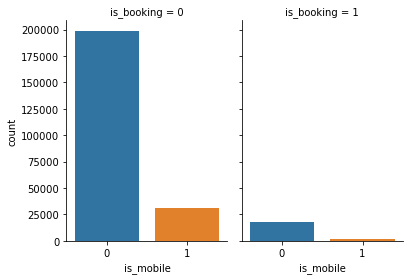

In [86]:
# see if bookings are done on mobile
g = sns.catplot(x="is_mobile", col="is_booking",
               data=train, kind="count",
               height=4, aspect=.7)

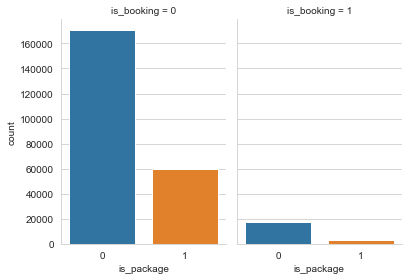

In [96]:
# see if bookings are done with a package
g = sns.catplot(x="is_package", col="is_booking",
               data=train, kind="count",
               height=4, aspect=.7)

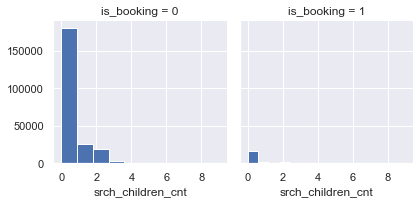

In [110]:
g = sns.FacetGrid(train,col="is_booking")
g.map(plt.hist,"srch_children_cnt")

c:\program files\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


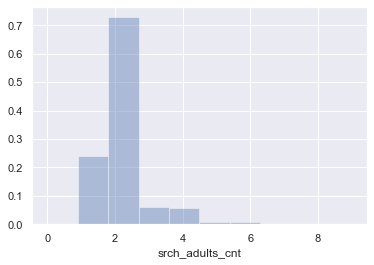

In [98]:
sns.distplot(train['srch_adults_cnt'], bins=10)

In [102]:
train['trip_m'] = pd.DatetimeIndex(train['srch_ci']).month

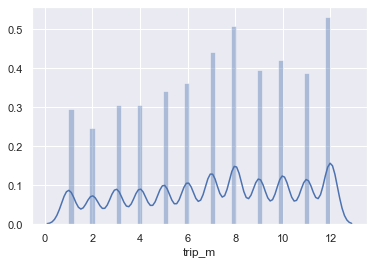

In [105]:
sns.distplot(train['trip_m'])

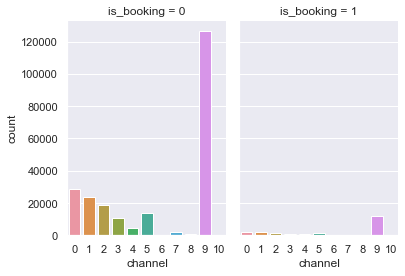

In [165]:
g = sns.catplot(x="channel", col="is_booking",
               data=train, kind="count",
               height=4, aspect=.7)

In [69]:
dests.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [116]:
train['trip_m'].fillna(method='ffill',inplace=True)

In [117]:
# zip up features going to use in model
features=list(zip(train['trip_m'],train['srch_children_cnt'], train['srch_destination_id'],train['is_booking']))

In [121]:
target=train['hotel_cluster']

In [160]:
model = KNeighborsClassifier(n_neighbors=5)

In [161]:
model.fit(features,target)

KNeighborsClassifier()

In [147]:
# test data set doesn't have is_booking, but all in test are successful bookings according to documentation
test['is_booking'] = 1

In [148]:
# There is a gnarly date out there, remove it
test = test[test['srch_ci'] < '2025']

In [149]:
test['srch_ci'] = pd.to_datetime(test['srch_ci'])
test['srch_co'] = pd.to_datetime(test['srch_co'])

In [150]:
test['trip_m'] = pd.DatetimeIndex(test['srch_ci']).month

In [151]:
fp=list(zip(test['trip_m'],test['srch_children_cnt'], test['srch_destination_id'],test['is_booking']))

In [162]:
predicted = model.predict(fp)

In [153]:
len(predicted)

249998

In [158]:
drop_indices = np.random.choice(target.index, 2, replace=False)
target_subset = target.drop(drop_indices)

In [163]:
print("Accuracy:",metrics.accuracy_score(target_subset, predicted))

Accuracy: 0.011460091680733446


In [166]:
### I'm clearly on the wrong track here

In [183]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import prerocessorForFeatures
from sklearn.pipeline import Pipeline

ImportError: cannot import name 'prerocessorForFeatures' from 'sklearn.preprocessing' (c:\program files\python37\lib\site-packages\sklearn\preprocessing\__init__.py)

In [173]:
nbClassifier = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [185]:
nb_model = Pipeline([('classifier', nbClassifier)])

In [186]:
nb_model.fit(features,target)

Pipeline(steps=[('classifier', MultinomialNB())])

In [188]:
nb_predict = nb_model.predict(fp)

In [189]:
print("Accuracy:",metrics.accuracy_score(target_subset, nb_predict))

Accuracy: 0.019076152609220874
